## Generation of the map band limited

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import camb

In [2]:
def generate_power_spectra_CAMB(Nside,  r=10**(-2), Alens=1, H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, type_power='total', typeless_bool=False):
    """
    Return [Cl^TT, Cl^EE, Cl^BB, Cl^TE]
    """
    lmax = 2*Nside
    # pars = camb.CAMBparams(max_l_tensor=lmax, parameterization='tensor_param_indeptilt')
    pars = camb.CAMBparams(max_l_tensor=lmax)
    pars.WantTensors = True

    pars.Accuracy.AccurateBB = True
    pars.Accuracy.AccuratePolarization = True
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau, Alens=Alens)
    pars.InitPower.set_params(As=2e-9, ns=ns, r=r, parameterization='tensor_param_indeptilt', nt=nt, ntrun=ntrun)
    pars.max_eta_k_tensor = lmax + 100  # 15000  # 100

    # pars.set_cosmology(H0=H0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=lens_potential_accuracy)

    print("Calculating spectra from CAMB !")
    results = camb.get_results(pars)

    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True, lmax=lmax)    
    if typeless_bool:
        return powers
    return powers[type_power]

In [ ]:
camb_test = generate_power_spectra_CAMB(512,  r=10**(-2), Alens=1, H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, type_power='total', typeless_bool=True)

Calculating spectra from CAMB !


In [3]:
# nside = 512
nside = 64*2
camb_cls = generate_power_spectra_CAMB(nside)

Calculating spectra from CAMB !


In [4]:
camb_cls.shape

(257, 4)

In [5]:
nside = 64
camb_cls = camb_cls[:2*nside+1,:]

In [6]:
maps_TQU = hp.synfast(camb_cls.T,nside, new=True)

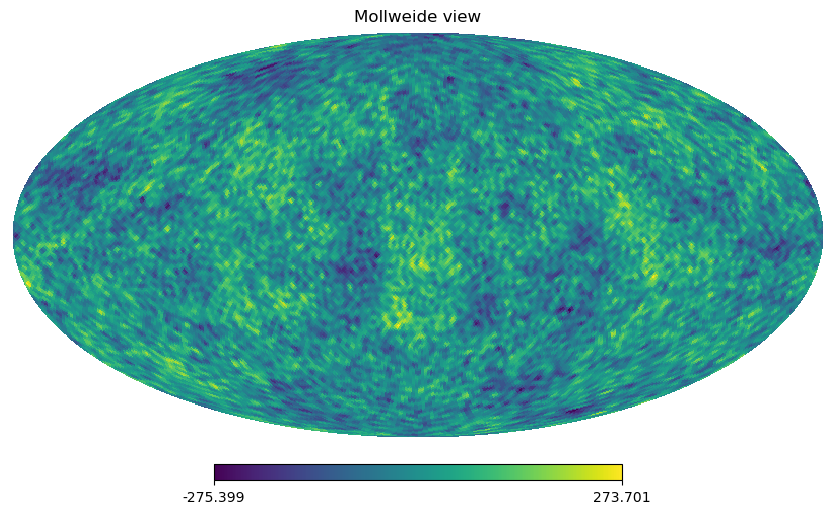

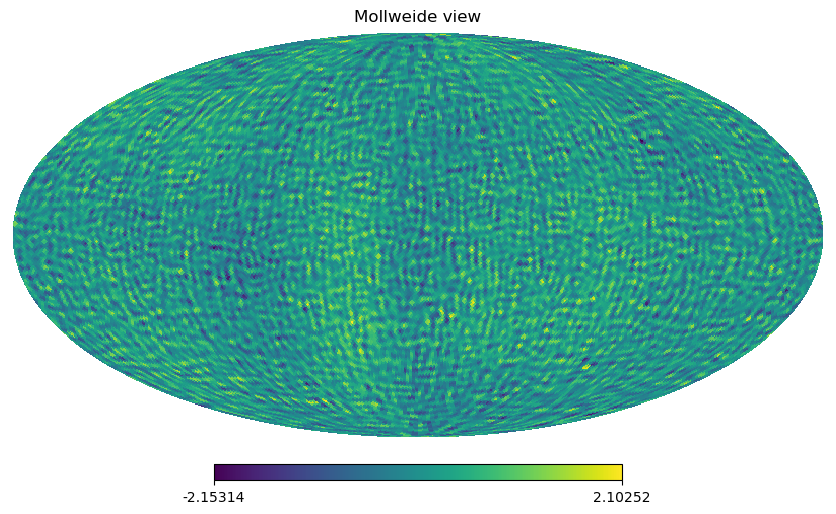

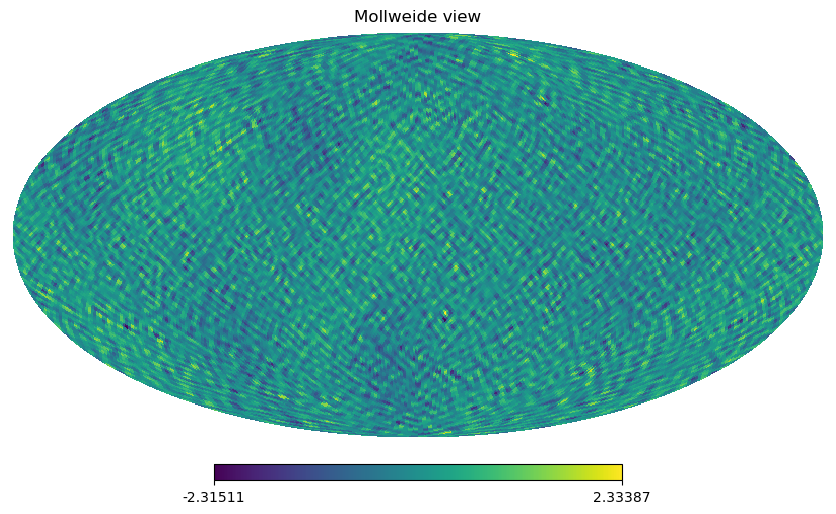

In [7]:
hp.mollview(maps_TQU[0])
hp.mollview(maps_TQU[1])
hp.mollview(maps_TQU[2])

Text(0.5, 1.0, 'U')

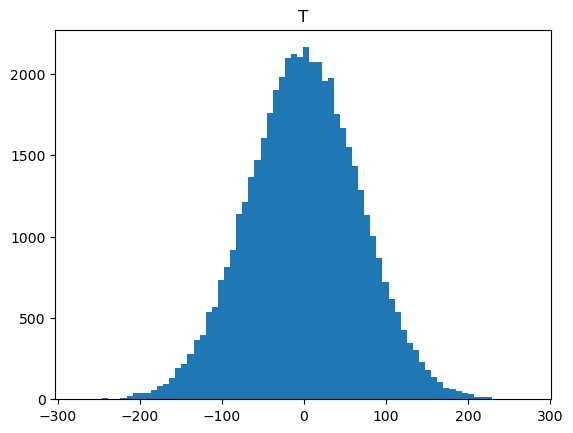

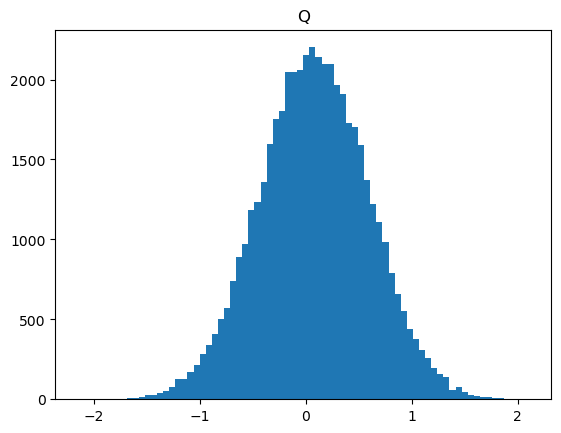

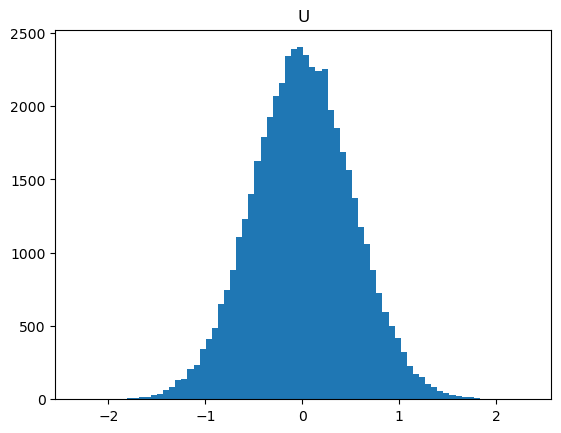

In [8]:
plt.figure()
plt.hist(maps_TQU[0], bins='rice')
plt.title('T')
plt.figure()
plt.hist(maps_TQU[1], bins='rice')
plt.title('Q')
plt.figure()
plt.hist(maps_TQU[2], bins='rice')
plt.title('U')

In [9]:
np.average(maps_TQU[0])

0.0003241762932111314

In [10]:
np.average(maps_TQU[1])

0.07760084597562399

In [11]:
np.average(maps_TQU[2])

0.0029145546229260126

In [12]:
cls_retrieved = hp.anafast(maps_TQU, lmax=2*nside)

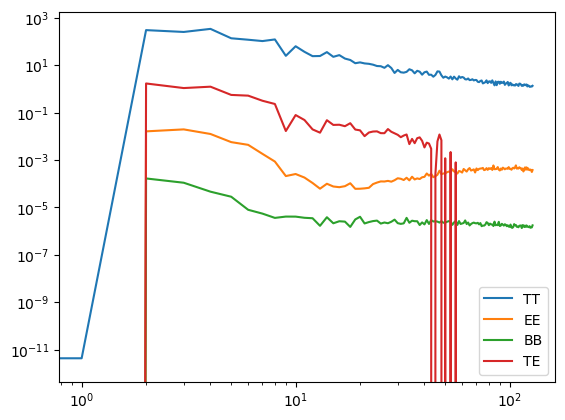

In [13]:
ell_arange = np.arange(cls_retrieved.shape[1])

plt.plot(ell_arange, cls_retrieved.T[:,:4])
plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

In [14]:
def save_map_Xpure_from_maps(maps_TQU_, directory_path='', outname=''):
    """ maps_TQU_ must have the dimension (3, 12*nside**2)
    """
    print('Shape maps TQU', maps_TQU_.shape)
    print('Recording 3-maps in', directory_path, outname)
    map_names = ['T', 'Q', 'U']
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH TO SAVE !!!')
        return
    list_hdu = [fits.PrimaryHDU(maps_TQU_)]
    list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=map_names[i], array=maps_TQU_[i,:], format='1D') for i in range(3)]))

    hdu_list = fits.HDUList(list_hdu)
    Header = fits.Header()
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)

In [15]:
# path_output_map = '/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/'
# outname = 'Map_test_band_limited.fits'
# save_map_Xpure_from_maps(maps_TQU, directory_path=path_output_map, outname=outname)
path_output_map = '/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/'
outname = 'Map_test_band_limited_128.fits'
save_map_Xpure_from_maps(maps_TQU, directory_path=path_output_map, outname=outname)



Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_128.fits


In [16]:
def save_fits_file_from_array(array_to_save, name_column_array, directory_path='', outname=''):
    """ Save arrays with corresponding name_column_array in directory_path+outname
        Note that the first index of the array_to_save will correspond to the number of columns recorded in the fits file

        To save c_ells, the array_to_save should be a vector in 1 dimension
        name_column_array must be a list of the name of the array, even if there is only 1 array
    """
    
    print('Shape array', array_to_save.shape)
    print('Recording 3-maps in', directory_path, outname)
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH GIVEN TO SAVE FITS FILE !')
    
    dimension_array = array_to_save.shape[0]

    list_hdu = [fits.PrimaryHDU(array_to_save)]
    if len(array_to_save.shape) == 1:
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[0], array=array_to_save, format='1D')]))
    else :
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[i], array=array_to_save[i,:], format='1D') for i in range(dimension_array)]))

    hdu_list = fits.HDUList(list_hdu)
    # Header = fits.Header()


    if directory_path[-1] != '/':
        directory_path += '/'
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)


In [55]:
save_fits_file_from_array(np.ravel(camb_cls[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128')
camb_cls_woTE = np.zeros_like(camb_cls)
camb_cls_woTE[:,:3] = camb_cls[:,:3]
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTE')
camb_cls_woTE[:,0] = 0
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTTTE')
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,1:3].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTTTE_v2')
camb_cls_only_BB = np.zeros_like(camb_cls)
camb_cls_only_BB[:,2] = camb_cls[:,2]
save_fits_file_from_array(np.ravel(camb_cls_only_BB[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_only_BB')
camb_cls_only_EEBB = np.zeros_like(camb_cls)
camb_cls_only_EEBB[:,1:3] = camb_cls[:,1:3]
save_fits_file_from_array(np.ravel(camb_cls_only_EEBB[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_only_EEBB')

Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTE
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTTTE
Shape array (256,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTTTE_v2
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_only_BB
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_only_EEBB


In [18]:
camb_cls_woTE[86:90,1:3]

array([[4.46057405e-04, 1.84500425e-06],
       [4.47840991e-04, 1.88210845e-06],
       [4.49554995e-04, 1.82225986e-06],
       [4.51005582e-04, 1.85969934e-06]])

In [19]:
# save_fits_file_from_array(np.ravel(camb_cls[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024')
# camb_cls_woTE = np.zeros_like(camb_cls)
# camb_cls_woTE[:,:3] = camb_cls[:,:3]
# save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024_woTE')
# camb_cls_woTE[:,0] = 0
# save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024_woTTTE')
# save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,1:3].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024_woTTTE_v2')

In [20]:
path_output_map = '/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/'
# outname = 'Map_test_band_limited_woTTTE.fits'
outname = 'Map_test_band_limited_woTE_128.fits'
maps_TQU_woTTTE = hp.synfast(camb_cls_woTE.T,nside, new=True)
save_map_Xpure_from_maps(maps_TQU_woTTTE, directory_path=path_output_map, outname=outname)


Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_woTE_128.fits


In [21]:
path_output_map = '/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/'
# outname = 'Map_test_band_limited_woTTTE.fits'
camb_cls_woTE_b = np.zeros_like(camb_cls)
camb_cls_woTE_b[:,:3] = camb_cls[:,:3]
outname = 'Map_test_band_limited_woTE_128.fits'
maps_TQU_woTE = hp.synfast(camb_cls_woTE_b.T,nside, new=True)
save_map_Xpure_from_maps(maps_TQU_woTE, directory_path=path_output_map, outname=outname)


Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_woTE_128.fits


In [56]:
path_output_map = '/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/'
# outname = 'Map_test_band_limited_woTTTE.fits'
# camb_cls_woTE_b = np.zeros_like(camb_cls)
# camb_cls_woTE_b[:,:3] = camb_cls[:,:3]
# outname = 'Map_test_band_limited_onlyBB_128.fits'
# maps_TQU_only_BB = hp.synfast(camb_cls_only_BB.T,nside, new=True)
outname = 'Map_test_band_limited_onlyEEBB_128.fits'
maps_TQU_only_EEBB = hp.synfast(camb_cls_only_EEBB.T,nside, new=True)
save_map_Xpure_from_maps(maps_TQU_only_EEBB, directory_path=path_output_map, outname=outname)


Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_onlyEEBB_128.fits


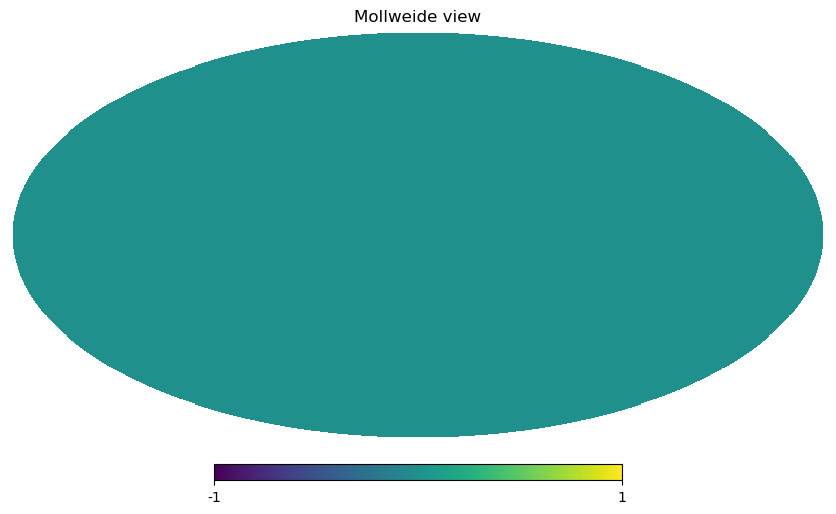

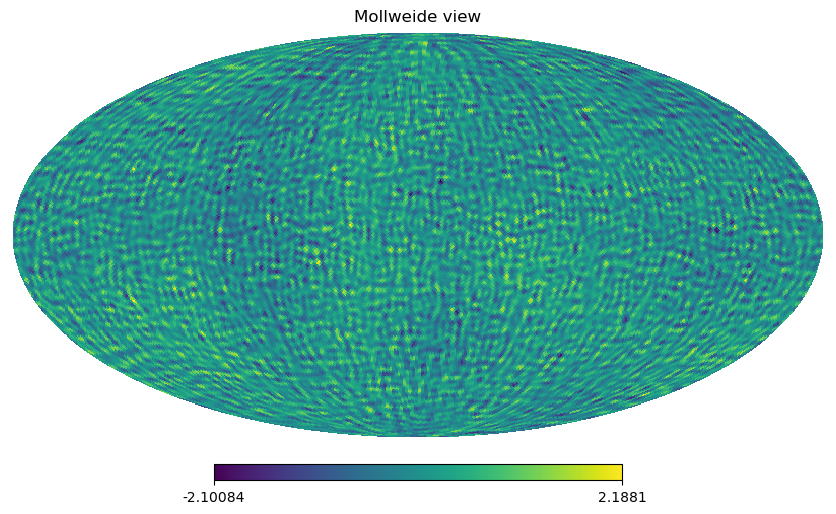

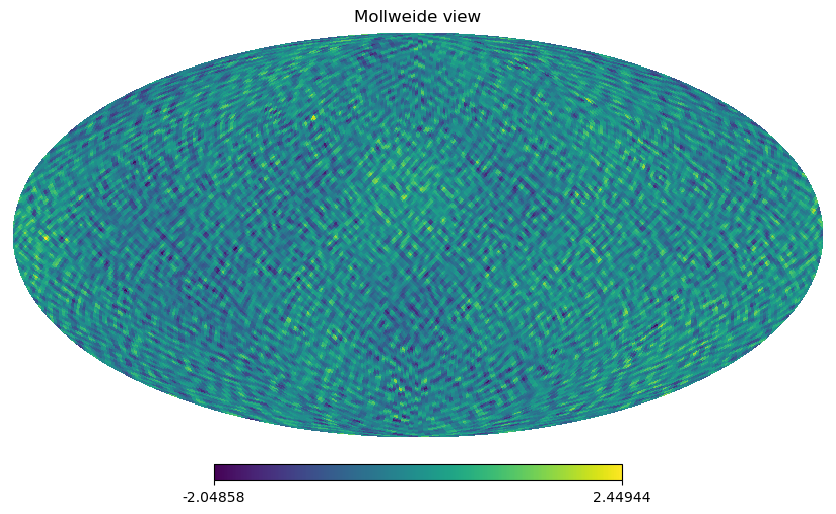

In [57]:
hp.mollview(maps_TQU_only_EEBB[0])
hp.mollview(maps_TQU_only_EEBB[1])
hp.mollview(maps_TQU_only_EEBB[2])

In [24]:
maps_TQU_woTTTE[2]

array([-0.13748143, -0.57160056,  0.76761575, ..., -0.2608611 ,
        0.07753731,  0.09276025])

In [25]:
cls_retrieved_woTTTE = hp.anafast(maps_TQU_woTTTE, lmax=2*nside)


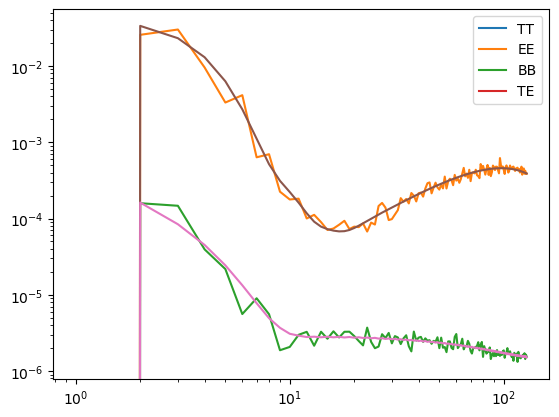

In [26]:
ell_arange = np.arange(cls_retrieved_woTTTE.shape[1])

plt.plot(ell_arange, cls_retrieved_woTTTE.T[:,:4])
plt.plot(ell_arange, camb_cls_woTE[:,:4])

plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

In [27]:
npix = 12*nside**2
np.ravel(maps_TQU_woTTTE, order='F')[2*npix:2*npix+50]

array([ 0.        , -0.10929788, -0.78038655,  0.        , -0.43626919,
        0.29133571,  0.        ,  0.4941678 , -0.26559168,  0.        ,
        0.00480177,  0.18315151,  0.        ,  0.16913441, -0.24385964,
        0.        ,  1.27321703, -0.31298349,  0.        , -0.92251712,
        1.27122359,  0.        ,  0.27783035,  0.49352905,  0.        ,
        0.30431047, -0.39094043,  0.        ,  0.33832787,  0.96491082,
        0.        ,  0.64408418,  0.16852503,  0.        ,  0.04695345,
        0.12992301,  0.        ,  0.17159637,  0.16105037,  0.        ,
        0.59731917, -0.61099898,  0.        ,  0.09781776,  0.65810577,
        0.        ,  0.42209102,  0.82739576,  0.        ,  0.16557862])

In [ ]:
dir_path = '/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/map_files/'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_{}.fits'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_bis_{}.fits'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_wpow_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_sq_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_unit_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_woTT_woTE_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_woTT_woTE_b_{}.fits'

new_dir_path = '/pscratch/sd/m/mag/WF_work/map_files_test_WF/'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver0_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit2_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit3_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit5_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit6_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver2_{}.fits' # Lower riangular
# path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver3_{}.fits' # Upper riangular
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver4_{}.fits' # Upper riangular

path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver5_{}.fits' # Upper riangular
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver6_{}.fits' # Lower riangular

path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_0_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_1_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_1b_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_woTE_1b_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_woTE_1c_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_woTE_1d_{}.fits' # Upper riangular -- wo TT TE

path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_BB_1d_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_BB_1c_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_BB_1b_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_BB_1a_{}.fits' # Upper riangular -- wo TT TE

path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_EEBB_1a_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_EEBB_1b_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_EEBB_1c_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_EEBB_1d_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_only_EEBB_1e_{}.fits' # Upper riangular -- wo TT TE

path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_2A_{}.fits' # Upper riangular -- wo TT TE
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_vtuned_2B_{}.fits' # Upper riangular -- wo TT TE

maps_output = np.ones((3,12*nside**2))

for i in range(3):
    maps_output[i] = hp.read_map(path_output_filtered_maps.format(i))

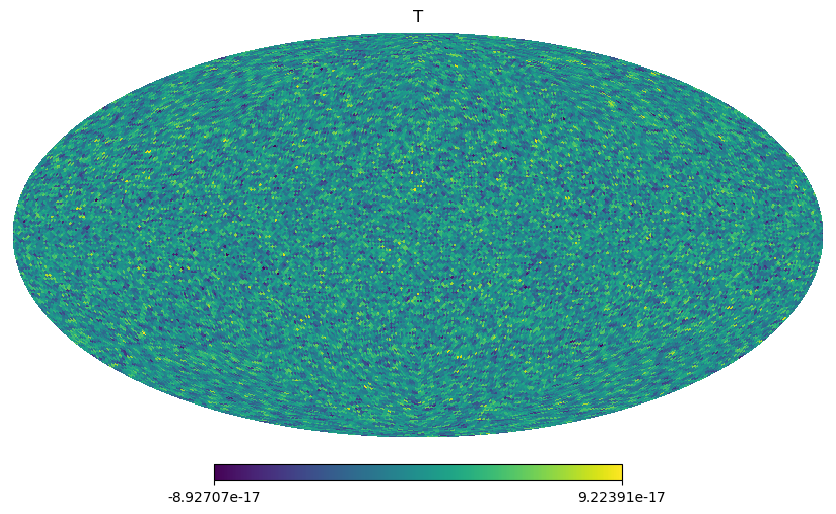

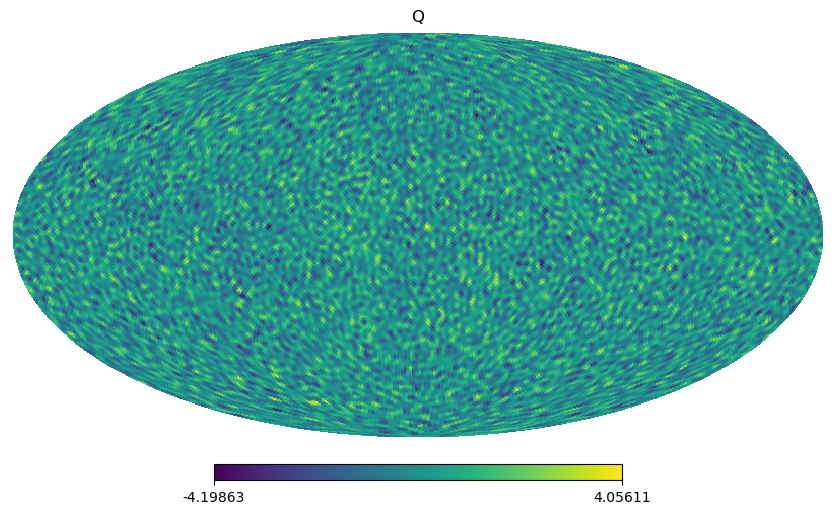

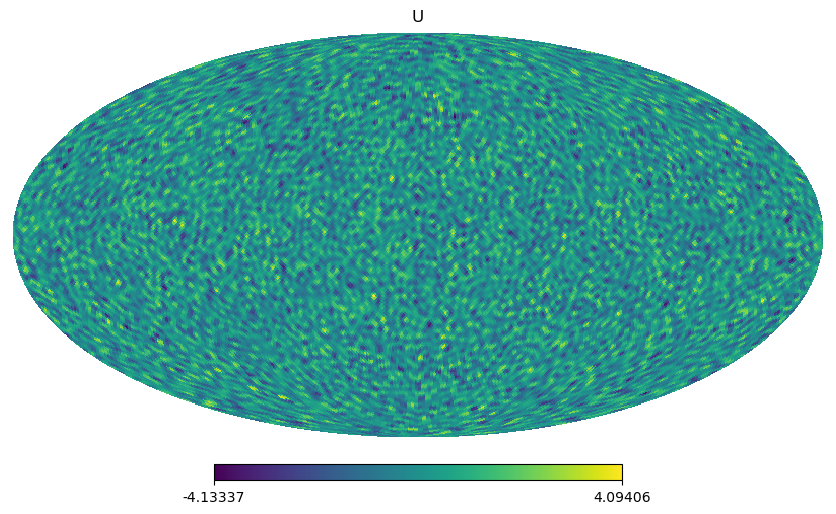

In [ ]:
hp.mollview(maps_output[0], title='T')
hp.mollview(maps_output[1], title='Q')
hp.mollview(maps_output[2], title='U')

Text(0.5, 1.0, 'U : rms = 0.993842554726501')

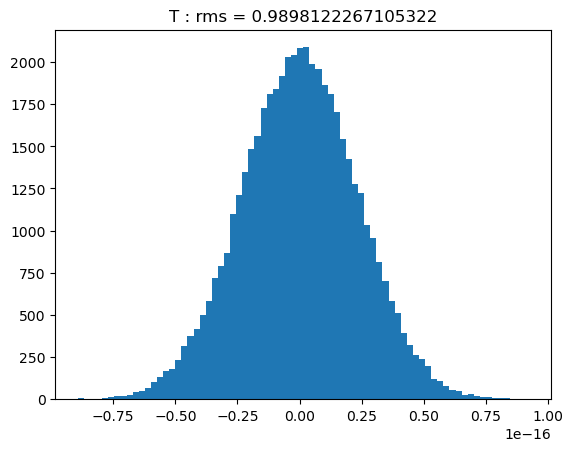

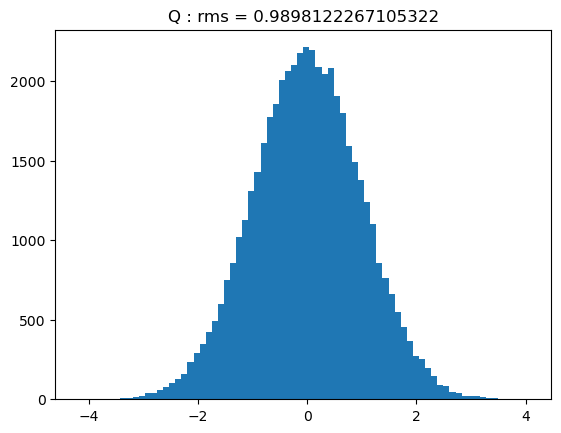

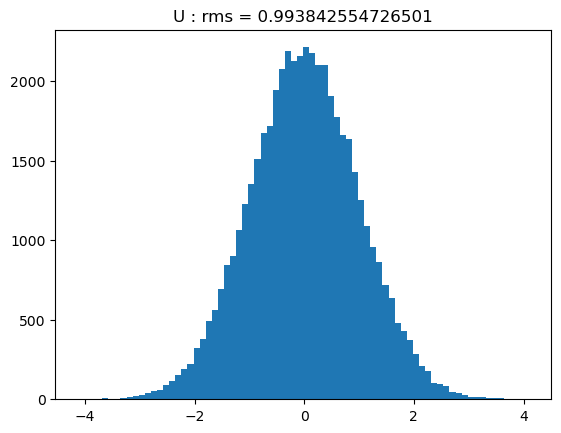

In [ ]:
rms_func = lambda map_to_analyze : np.sqrt(np.sum(np.power(map_to_analyze-np.mean(map_to_analyze), 2))/len(map_to_analyze))
rms_T = rms_func(maps_output[0])
rms_Q = rms_func(maps_output[1])
rms_U = rms_func(maps_output[2])


plt.figure()
plt.hist(maps_output[0], bins='rice')
plt.title("T : rms = {}".format(rms_Q))
plt.figure()
plt.hist(maps_output[1], bins='rice')
plt.title("Q : rms = {}".format(rms_Q))
plt.figure()
plt.hist(maps_output[2], bins='rice')
plt.title('U : rms = {}'.format(rms_U))

In [ ]:
c_ells_output = hp.anafast(maps_output, lmax=2*nside)


In [81]:
nspec = 3
# c_ells_file = hp.anafast(map_file, lmax=2*nside)
# fits_file = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_prewitened_newver_woTTTE_vtuned_0.fits")
# fits_file = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_prewitened_newver_woTTTE_vtuned_1b.fits")
# fits_file = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_prewitened_newver_woTE_vtuned_1b.fits")
fits_file = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_prewitened_newver_only_BB_vtuned_1b.fits")

c_ells_file = fits_file[1].data['VECT']

c_ells_file = c_ells_file.reshape((nspec,2*nside))

# fits_file_whitened = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_witened_newver_woTTTE_vtuned_0.fits")
# fits_file_whitened = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_witened_newver_woTTTE_vtuned_1b.fits")
# fits_file_whitened = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_witened_newver_WOTE_vtuned_1b.fits")
fits_file_whitened = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_witened_newver_only_BB_vtuned_1b.fits")
c_ells_file_whitened = fits_file_whitened[1].data['VECT']

c_ells_file_whitened = c_ells_file.reshape((nspec,2*nside))

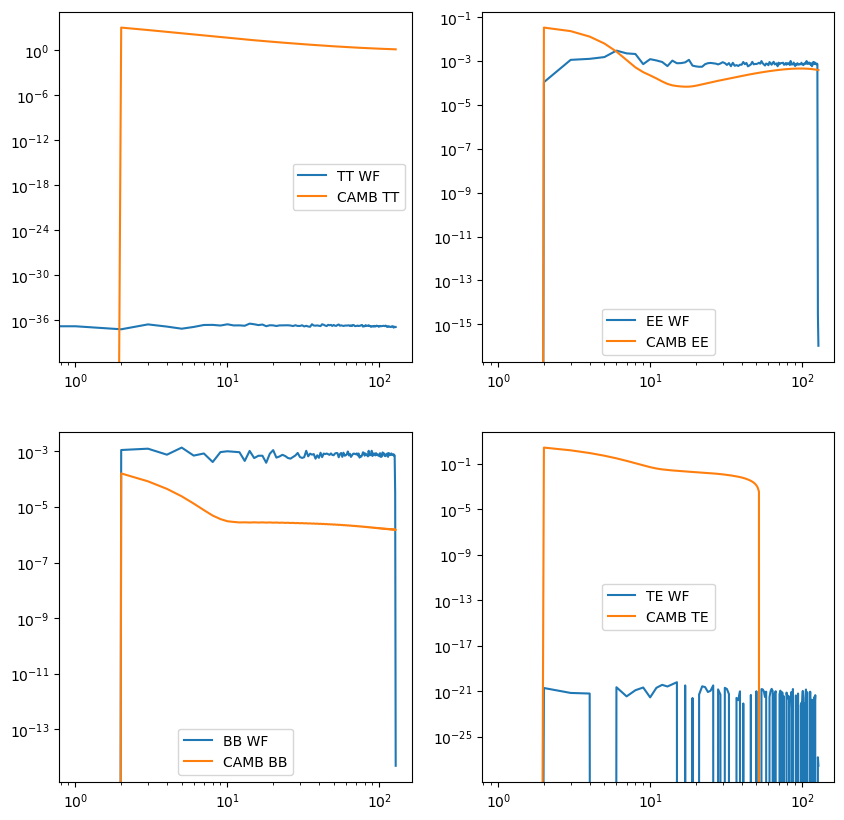

In [83]:
ell_arange = np.arange(c_ells_output.shape[1])
ell_CAMB = np.arange(camb_cls.shape[0])
ell_file = np.arange(c_ells_file.shape[1])

list_correl = ['TT', 'EE', 'BB', 'TE']


plt.figure(figsize=(10,10))
for i in range(4):
    # plt.subplot(221+i)
    plt.subplot(221+i)
    plt.plot(ell_arange, c_ells_output.T[:,i], label='{} WF'.format(list_correl[i]))
    plt.plot(ell_CAMB, camb_cls[:,i], label='CAMB {}'.format(list_correl[i]))
    # plt.plot(ell_CAMB, camb_cls_only_EEBB[:,i], label='CAMB {}'.format(list_correl[i]))
    # plt.plot(ell_CAMB, c_ells_file.T[:,i+1], label='pre-whitened {}'.format(list_correl[i+1]))
    # if i<3:
        # plt.plot(ell_file, c_ells_file[i,:], label='pre-whitened {}'.format(list_correl[i]))
        # plt.plot(ell_file[1:], divided_spectra[i,:], '-.', label='file/theory {}'.format(list_correl[i+1]))
        # plt.plot(ell_file, c_ells_file_whitened[i,:], '-.', label='whitened {}'.format(list_correl[i]))
    plt.loglog()
    plt.legend()

plt.show()

## NSTOKES = 2 !

In [25]:
new_dir_path = '/pscratch/sd/m/mag/WF_work/map_files_test_WF/'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_v2_0_{}.fits' # Upper riangular -- wo TT TE -- Unit
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_v2_1_{}.fits' # Upper riangular -- wo TT TE -- True test
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_vtuned_1_{}.fits' # Upper riangular -- wo TT TE -- True test
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_vtuned_1b_{}.fits' # Upper riangular -- wo TT TE -- True test
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_vtuned_2_{}.fits' # Upper riangular -- wo TT TE -- True test --- with coeffs = 2*ell+1
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_vtuned_3_{}.fits' # Upper riangular -- wo TT TE -- True test
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_vtuned_4_{}.fits' # Upper riangular -- wo TT TE -- with coeffs = sum((2*ell+1)/(4*np.pi))
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_vtuned_5_{}.fits' # Upper riangular -- wo TT TE -- with coeffs = 1/sum((2*ell+1)/(4*np.pi))
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_vtuned_5b_{}.fits' # Upper riangular -- wo TT TE -- with coeffs = 1/sum((2*ell+1)/(4*np.pi))

maps_output = np.zeros((3,12*nside**2))

for i in range(2):
    maps_output[i+1] = hp.read_map(path_output_filtered_maps.format(i))


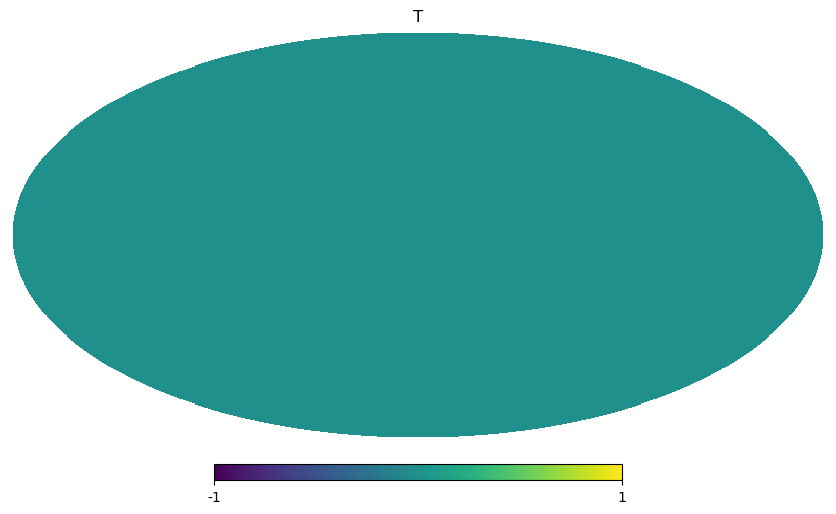

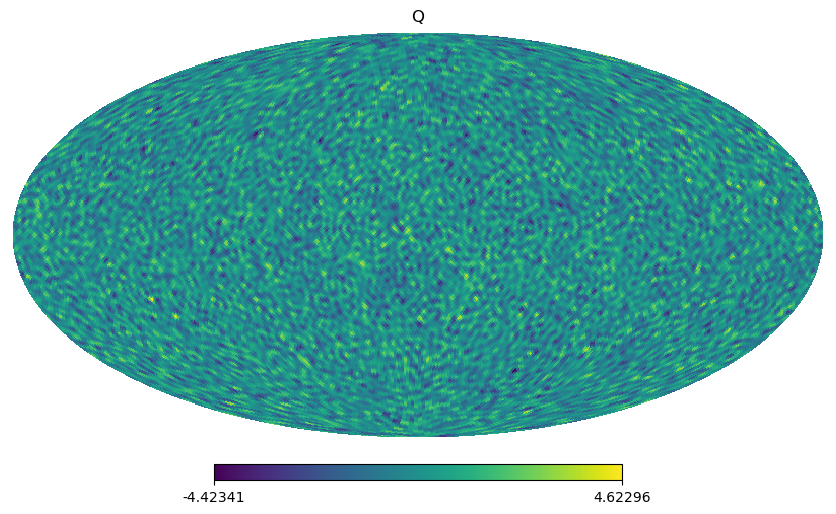

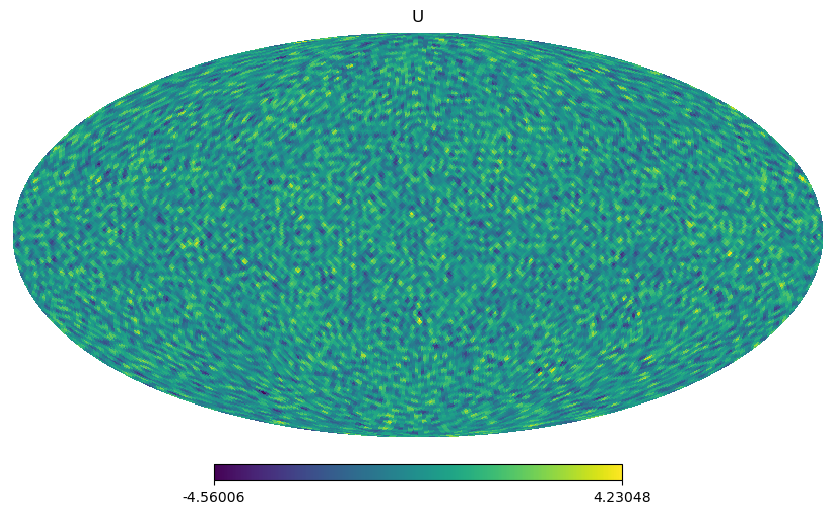

In [26]:
hp.mollview(maps_output[0], title='T')
hp.mollview(maps_output[1], title='Q')
hp.mollview(maps_output[2], title='U')

Text(0.5, 1.0, 'U : rms = 1.0100107315376563')

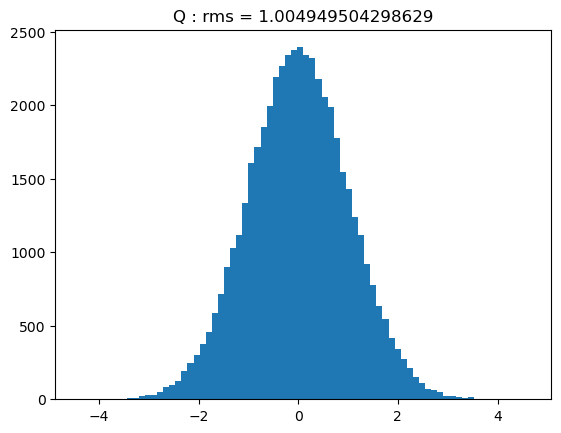

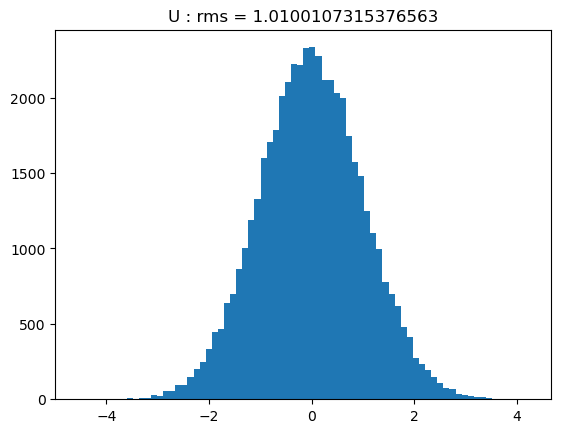

In [27]:
rms_Q = np.sqrt(np.sum(np.power(maps_output[1]-np.mean(maps_output[1]), 2))/len(maps_output[1]))
rms_U = np.sqrt(np.sum(np.power(maps_output[2]-np.mean(maps_output[2]), 2))/len(maps_output[2]))


plt.figure()
plt.hist(maps_output[1], bins='rice')
plt.title('Q : rms = {}'.format(rms_Q))
plt.figure()
plt.hist(maps_output[2], bins='rice')
plt.title('U : rms = {}'.format(rms_U))

In [28]:
c_ells_output = hp.anafast(maps_output, lmax=2*nside)


In [29]:
fits_file = fits.open('/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/Map_test_band_limited_woTTTE_128.fits')

map_file = np.zeros((3,12*nside**2))
map_file[0] = fits_file[1].data['T']
map_file[1] = fits_file[1].data['Q']
map_file[2] = fits_file[1].data['U']

In [30]:

# c_ells_file = hp.anafast(map_file, lmax=2*nside)
fits_file = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_prewitened_newver_woTTTE_vtuned_0.fits")
fits_file = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_prewitened_newver_woTTTE_vtuned_1b.fits")
c_ells_file = fits_file[1].data['VECT']

c_ells_file = c_ells_file.reshape((2,2*nside))

fits_file_whitened = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_witened_newver_woTTTE_vtuned_0.fits")
fits_file_whitened = fits.open("/pscratch/sd/m/mag/WF_work/map_files_test_WF/cell_witened_newver_woTTTE_vtuned_1b.fits")
c_ells_file_whitened = fits_file_whitened[1].data['VECT']

c_ells_file_whitened = c_ells_file.reshape((2,2*nside))

In [31]:

divided_spectra = np.zeros((2, 2*nside-1))
for i in range(2):
    divided_spectra[i,:] = c_ells_file[i,1:]/camb_cls_woTE[2:,i+1]

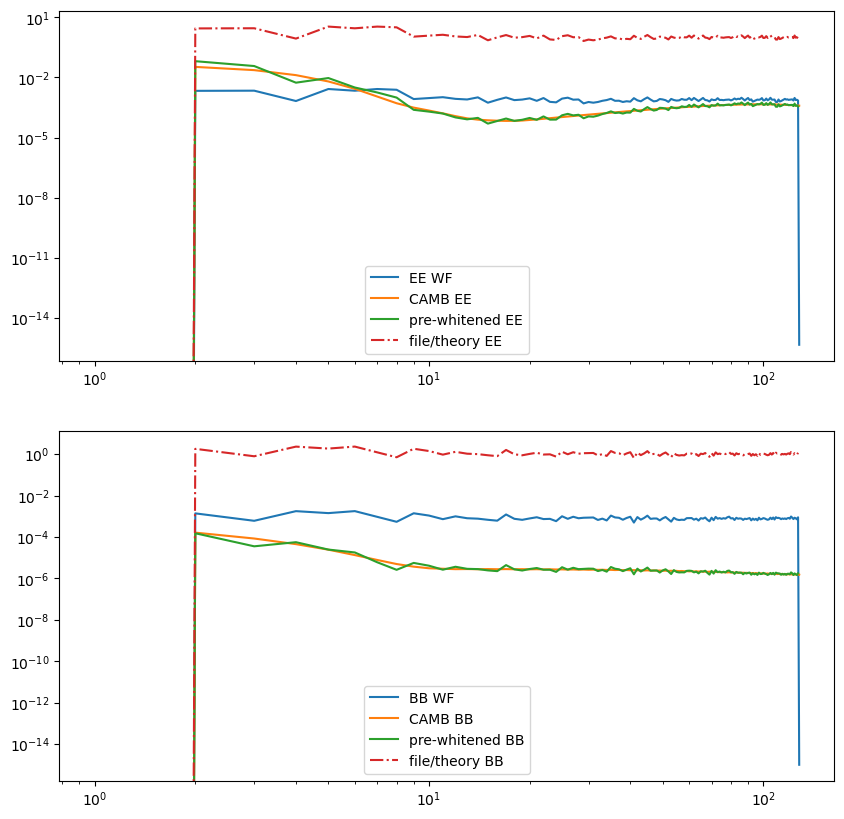

In [33]:
ell_arange = np.arange(c_ells_output.shape[1])
ell_CAMB = np.arange(camb_cls.shape[0])
ell_file = np.arange(c_ells_file.shape[1])

list_correl = ['TT', 'EE', 'BB', 'TE']


plt.figure(figsize=(10,10))
for i in range(2):
    # plt.subplot(221+i)
    plt.subplot(211+i)
    plt.plot(ell_arange, c_ells_output.T[:,i+1], label='{} WF'.format(list_correl[i+1]))
    plt.plot(ell_CAMB, camb_cls_woTE[:,i+1], label='CAMB {}'.format(list_correl[i+1]))
    # plt.plot(ell_CAMB, c_ells_file.T[:,i+1], label='pre-whitened {}'.format(list_correl[i+1]))
    plt.plot(ell_file, c_ells_file[i,:], label='pre-whitened {}'.format(list_correl[i+1]))
    # plt.plot(ell_file[1:], divided_spectra[i,:], '-.', label='file/theory {}'.format(list_correl[i+1]))
    # plt.plot(ell_file, c_ells_file_whitened[i,:], label='whitened {}'.format(list_correl[i+1]))
    plt.loglog()
    plt.legend()

plt.show()

In [72]:
divided_spectra[0,:]/c_ells_output.T[2:,1]

array([0.00000000e+00, 1.15461292e+01, 2.39001678e+01, 2.81313300e+00,
       2.70802062e+01, 9.82755967e+00, 1.67826721e+01, 2.10874386e+01,
       3.18269658e+01, 1.41465496e+01, 4.18424879e+01, 1.91373672e+01,
       5.90785881e+01, 2.63802882e+01, 3.20354671e+01, 3.08025644e+01,
       5.20720806e+01, 3.30021363e+01, 3.69940410e+01, 4.49726365e+01,
       6.60928432e+01, 3.34645342e+01, 4.56892490e+01, 4.66564095e+01,
       6.45054046e+01, 6.05216927e+01, 4.35111878e+01, 6.46546671e+01,
       8.54525521e+01, 5.18543509e+01, 6.04231134e+01, 8.35660783e+01,
       6.21152764e+01, 5.64600047e+01, 6.89851443e+01, 1.04219922e+02,
       7.20140754e+01, 7.48052886e+01, 8.26919330e+01, 8.99856496e+01,
       6.76477168e+01, 9.91355465e+01, 9.96940979e+01, 8.30275132e+01,
       9.02831252e+01, 9.46007514e+01, 7.73435356e+01, 1.30429070e+02,
       1.05463687e+02, 8.07252246e+01, 1.62851985e+02, 7.35841973e+01,
       1.14443550e+02, 1.04500096e+02, 1.19013679e+02, 1.23024491e+02,
      

## Divided spectra test

In [92]:
full_cell_file = np.zeros((2*nside+1,4))
full_cell_file[1:,1:3] = c_ells_file.T

map_full_cell_file = hp.synfast(full_cell_file.T, nside=64, new=True)

Text(0.5, 1.0, 'U')

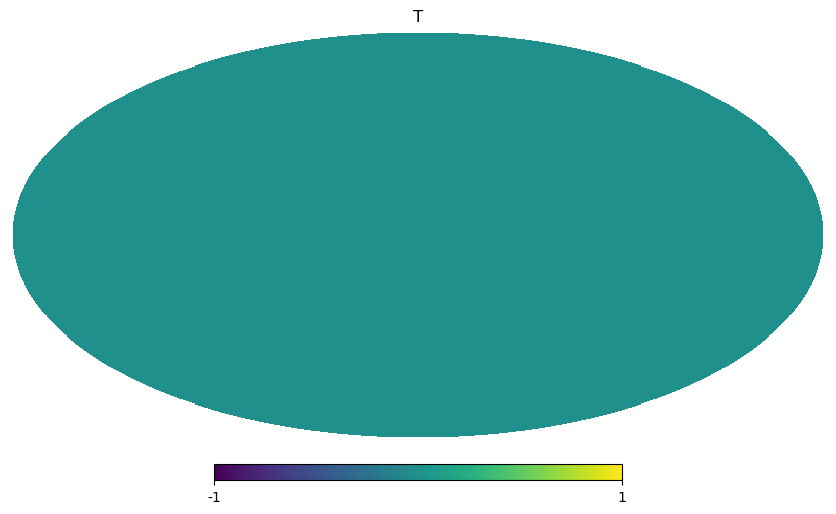

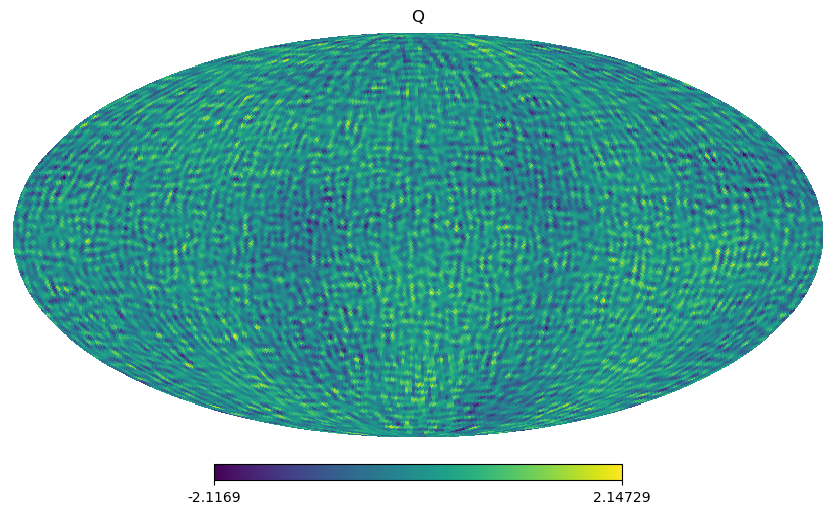

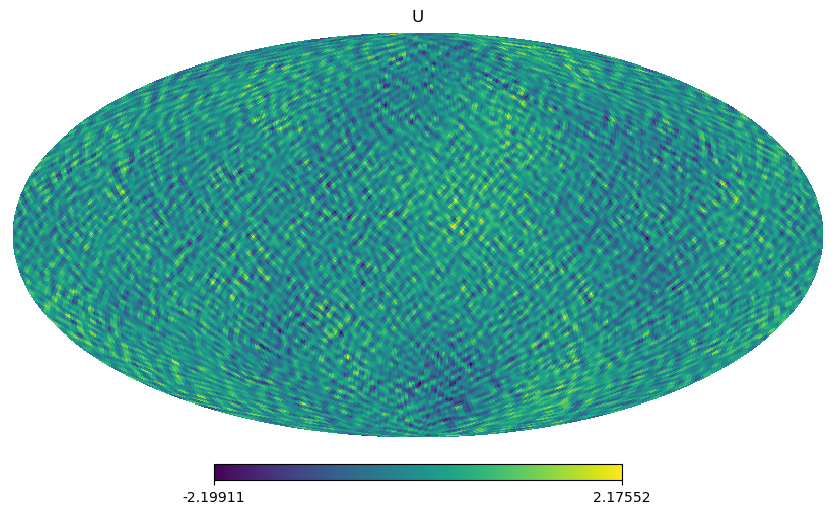

In [93]:
hp.mollview(map_full_cell_file[0])
plt.title('T')
hp.mollview(map_full_cell_file[1])
plt.title('Q')
hp.mollview(map_full_cell_file[2])
plt.title('U')

In [82]:
divided_spectra.shape

(2, 127)

In [94]:
divided_spectra

array([[0.        , 1.70200045, 1.22224183, 1.0591993 , 1.66523863,
        3.41373774, 1.48417773, 2.71338059, 0.72922489, 1.1000143 ,
        0.97665908, 0.96524771, 1.17038515, 1.17212272, 1.46623705,
        1.28044311, 1.20992003, 1.37567709, 0.83740279, 0.97816432,
        0.80209116, 0.76888434, 0.81475244, 0.79690995, 0.72292172,
        1.03905174, 1.01086078, 0.79763567, 1.00185975, 0.83678108,
        0.94312104, 1.00287476, 0.81682784, 1.05912026, 0.9487909 ,
        1.00243414, 1.10543696, 0.79891157, 0.80801281, 0.97208073,
        1.22639866, 0.71342164, 1.11472705, 0.84941706, 0.70248738,
        1.11027556, 0.81424527, 0.90646424, 0.94038643, 0.91307843,
        0.82518775, 1.20208821, 0.93479738, 0.77125378, 1.07608873,
        1.07923854, 1.15372562, 1.037841  , 0.85941303, 1.06698966,
        0.89769765, 0.97284275, 1.08521724, 1.16103793, 1.00461576,
        0.96286992, 1.02585529, 0.84857862, 0.99329855, 0.99050365,
        0.77802249, 0.9857722 , 1.05697548, 0.88

In [192]:
hp.nside2resol(64), 1/hp.nside2resol(64)

(0.015989479811663883, 62.54112152357375)

In [194]:
1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))), (np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1)))

(0.023325130288589888, 42.87221497275738)

In [190]:
full_cell_divided_spectra_0 = np.zeros((2*nside+1,4))
# full_cell_divided_spectra[2:,1:3] = divided_spectra.T
# full_cell_divided_spectra_0[2:,0] = 1
full_cell_divided_spectra_0[2:,0] = 1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1)))


map_divided_spectra_0 = hp.synfast(full_cell_divided_spectra_0.T, nside=nside, new=True)

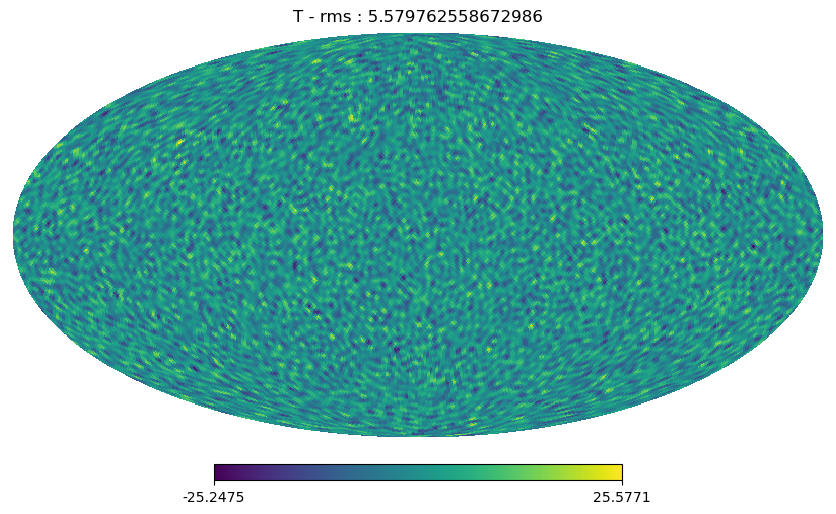

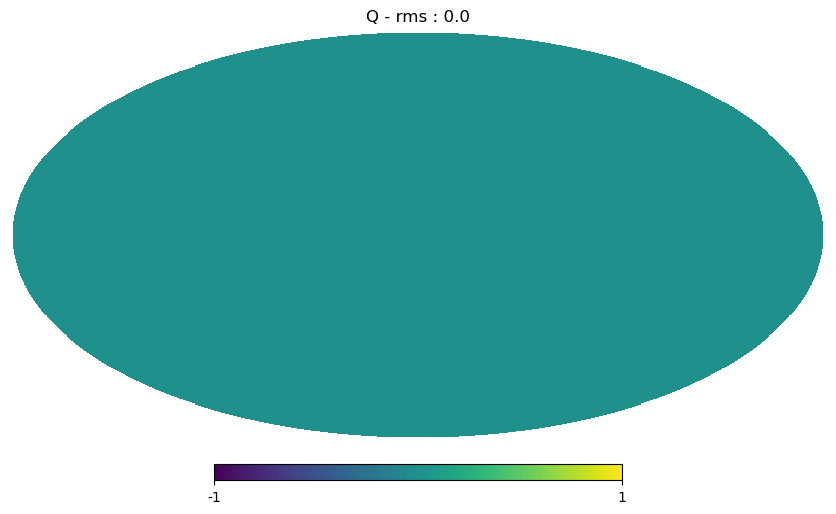

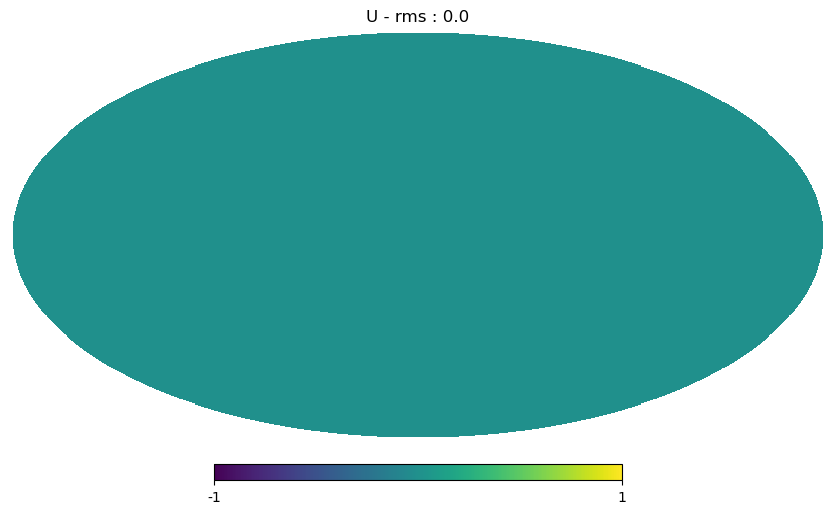

In [191]:
map_to_take_rms = map_divided_spectra_0
# rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i], 2))/len(map_[i]))

rms_T_0 = rms_func(map_to_take_rms, 0)
rms_Q_0 = rms_func(map_to_take_rms, 1)
rms_U_0 = rms_func(map_to_take_rms, 2)
# rms_Q_b = np.sqrt(np.sum(np.power(map_divided_spectra_b[1]-np.mean(map_divided_spectra_b[1]), 2))/len(map_divided_spectra_b[1]))
# rms_U_b = np.sqrt(np.sum(np.power(map_divided_spectra_b[2]-np.mean(map_divided_spectra_b[2]), 2))/len(map_divided_spectra_b[2]))

hp.mollview(map_divided_spectra_0[0])
plt.title('T - rms : {}'.format(rms_T_0))
hp.mollview(map_divided_spectra_0[1])
plt.title('Q - rms : {}'.format(rms_Q_0))
hp.mollview(map_divided_spectra_0[2])
plt.title('U - rms : {}'.format(rms_U_0))
plt.show()

In [129]:
full_cell_divided_spectra = np.zeros((2*nside+1,4))
# full_cell_divided_spectra[2:,1:3] = divided_spectra.T
full_cell_divided_spectra[2:,1:3] = 1
# full_cell_divided_spectra[2:,1:3] = 1/np.sqrt(2)


map_divided_spectra = hp.synfast(full_cell_divided_spectra.T, nside=64, new=True)

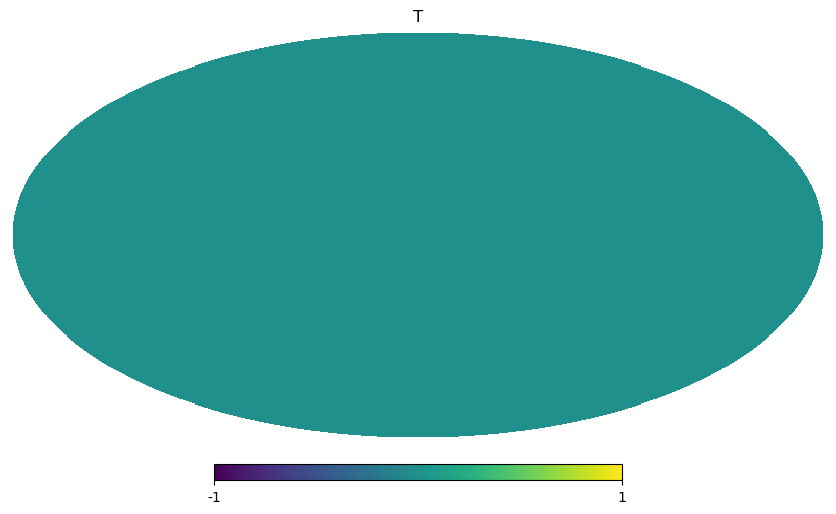

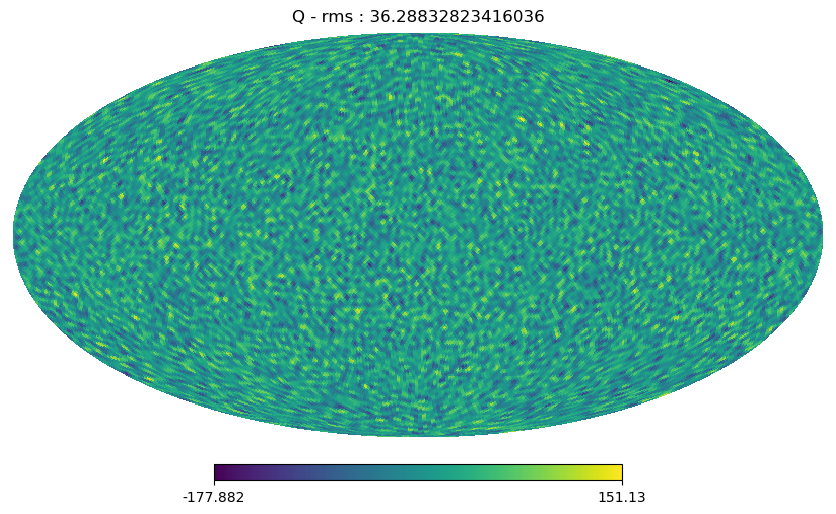

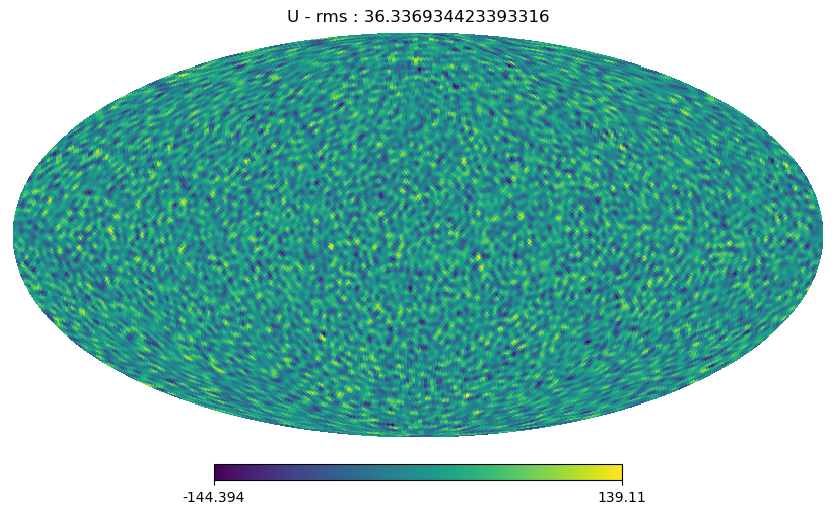

In [130]:
rms_Q = np.sqrt(np.sum(np.power(map_divided_spectra[1]-np.mean(map_divided_spectra[1]), 2))/len(map_divided_spectra[1]))
rms_U = np.sqrt(np.sum(np.power(map_divided_spectra[2]-np.mean(map_divided_spectra[2]), 2))/len(map_divided_spectra[2]))

hp.mollview(map_divided_spectra[0])
plt.title('T')
hp.mollview(map_divided_spectra[1])
plt.title('Q - rms : {}'.format(rms_Q))
hp.mollview(map_divided_spectra[2])
plt.title('U - rms : {}'.format(rms_U))
plt.show()

In [196]:
nside_b = 32
full_cell_divided_spectra_b = np.zeros((2*nside_b+1,4))
# full_cell_divided_spectra[2:,1:3] = divided_spectra.T
# full_cell_divided_spectra[2:,1:3] = 1
full_cell_divided_spectra_b[2:,1:3] = 1/(np.sum((4*np.pi)/(2*(np.arange(2*nside_b+1)) + 1)))



map_divided_spectra_b = hp.synfast(full_cell_divided_spectra_b.T, nside=nside_b, new=True) #, pixwin=True)

In [197]:
np.mean(map_divided_spectra_b[1])

-0.019695108477657118

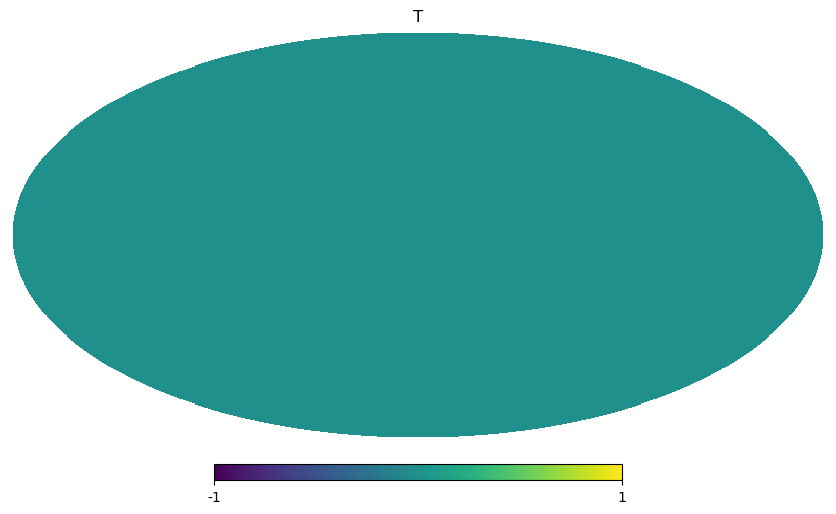

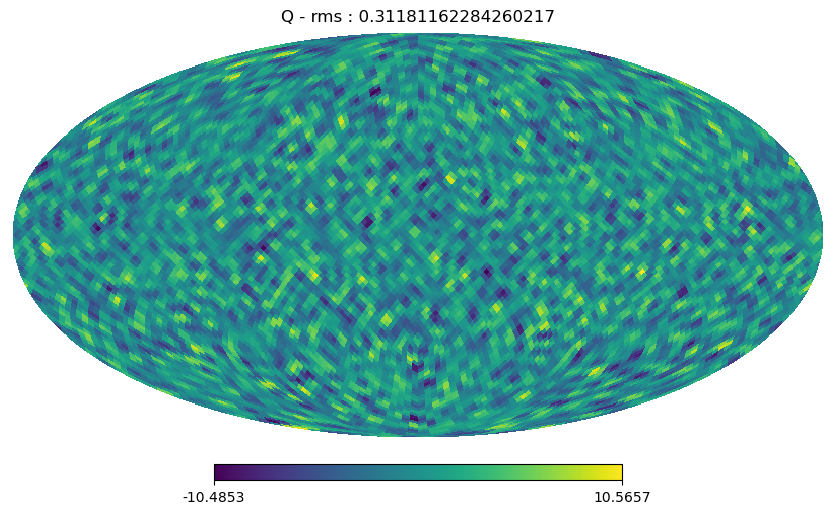

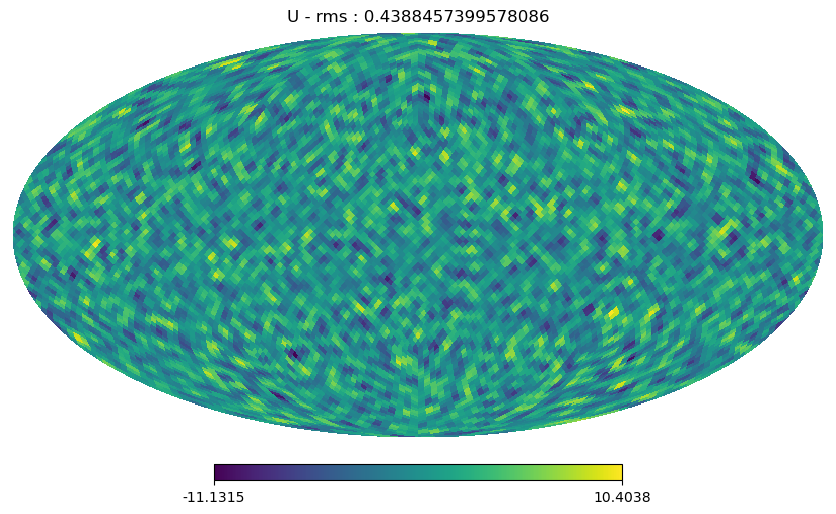

In [199]:
map_to_take_rms = map_divided_spectra_e
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))
# rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i], 2))/len(map_[i]))

rms_Q_b = rms_func(map_to_take_rms, 1)
rms_U_b = rms_func(map_to_take_rms, 2)
# rms_Q_b = np.sqrt(np.sum(np.power(map_divided_spectra_b[1]-np.mean(map_divided_spectra_b[1]), 2))/len(map_divided_spectra_b[1]))
# rms_U_b = np.sqrt(np.sum(np.power(map_divided_spectra_b[2]-np.mean(map_divided_spectra_b[2]), 2))/len(map_divided_spectra_b[2]))

hp.mollview(map_divided_spectra_b[0])
plt.title('T')
hp.mollview(map_divided_spectra_b[1])
plt.title('Q - rms : {}'.format(rms_Q_b))
hp.mollview(map_divided_spectra_b[2])
plt.title('U - rms : {}'.format(rms_U_b))
plt.show()

In [144]:
print('nside=1', np.std(map_divided_spectra_e[1]), np.std(map_divided_spectra_e[2]))
print('nside=2', np.std(map_divided_spectra_d[1]), np.std(map_divided_spectra_d[2]), np.std(map_divided_spectra_d[1])/np.std(map_divided_spectra_e[1]))
print('nside=16', np.std(map_divided_spectra_c[1]), np.std(map_divided_spectra_c[2]), np.std(map_divided_spectra_c[1])/np.std(map_divided_spectra_d[1]), np.std(map_divided_spectra_c[1])/np.std(map_divided_spectra_e[1]))
print('nside=32', np.std(map_divided_spectra_b[1]), np.std(map_divided_spectra_b[2]), np.std(map_divided_spectra_b[1])/np.std(map_divided_spectra_d[1]), np.std(map_divided_spectra_d[1])/np.std(map_divided_spectra_e[1]))
print('nside=64', np.std(map_divided_spectra[1]), np.std(map_divided_spectra[2]), np.std(map_divided_spectra[1])/np.std(map_divided_spectra_b[1]), np.std(map_divided_spectra[1])/np.std(map_divided_spectra_e[1]))

nside=1 0.31181162284260217 0.4388457399578086
nside=2 1.2045245711760766 1.21303521200731 3.8629880444966687
nside=16 9.814151053364515 9.319446036452902 8.14773835936128 31.474615871899527
nside=32 18.232295548692072 17.919244406209966 15.1365077848851 3.8629880444966687
nside=64 36.28832823416036 36.336934423393316 1.990332382296401 116.37901083782937


In [145]:
31.474615871899527/3.8629880444966687

8.14773835936128

In [146]:
116.37901083782937/3.8629880444966687

30.126681599138387

In [147]:
116.37901083782937/31.474615871899527

3.6975514272036696

In [151]:
1/hp.nside2resol(64)

62.54112152357375

In [138]:
nside_c = 16
full_cell_divided_spectra_c = np.zeros((2*nside_c+1,4))
# full_cell_divided_spectra[2:,1:3] = divided_spectra.T
full_cell_divided_spectra_c[2:,1:3] = 1
# full_cell_divided_spectra_c[2:,1:3] = 1/np.sqrt(12*nside_c**2)



map_divided_spectra_c = hp.synfast(full_cell_divided_spectra_c.T, nside=nside_c, new=True)

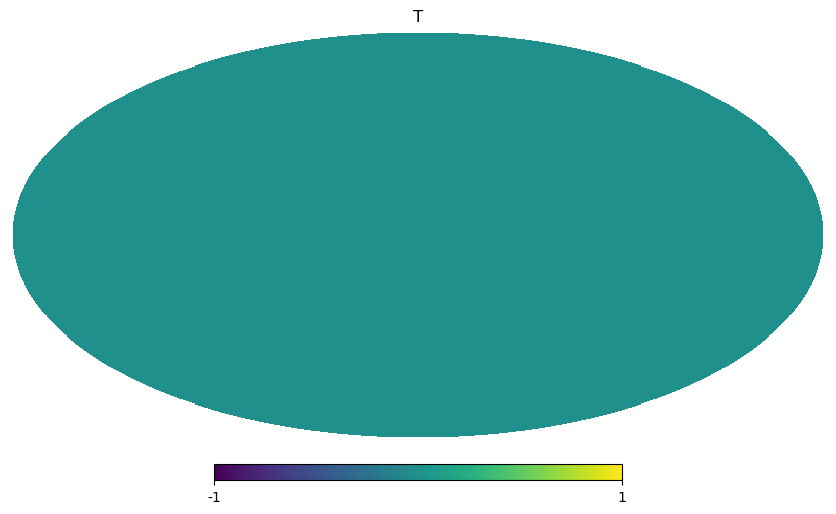

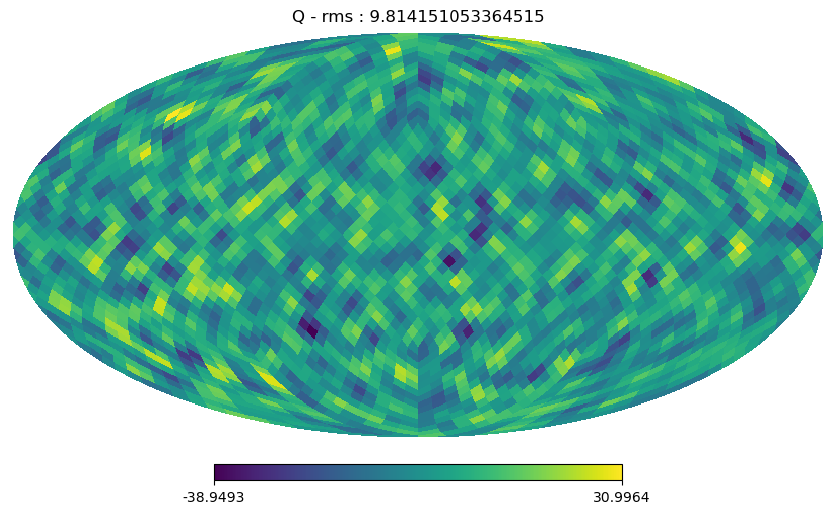

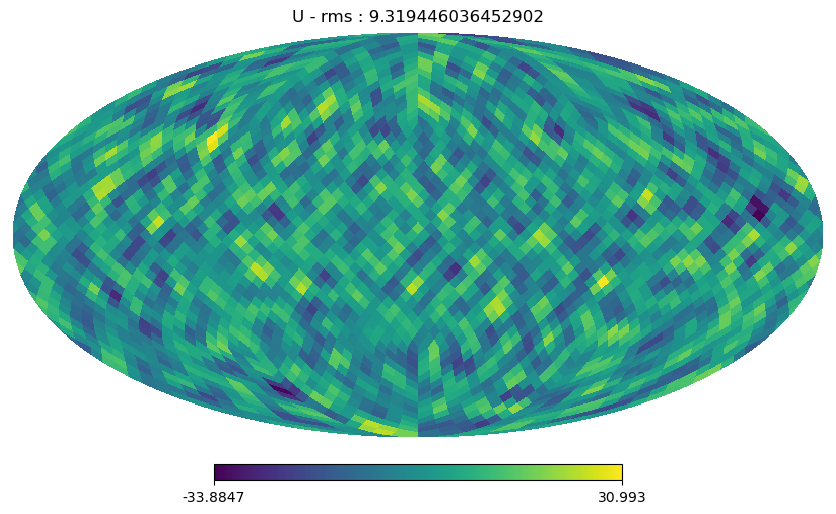

In [139]:
rms_Q_c = np.sqrt(np.sum(np.power(map_divided_spectra_c[1]-np.mean(map_divided_spectra_c[1]), 2))/len(map_divided_spectra_c[1]))
rms_U_c = np.sqrt(np.sum(np.power(map_divided_spectra_c[2]-np.mean(map_divided_spectra_c[2]), 2))/len(map_divided_spectra_c[2]))

hp.mollview(map_divided_spectra_c[0])
plt.title('T')
hp.mollview(map_divided_spectra_c[1])
plt.title('Q - rms : {}'.format(rms_Q_c))
hp.mollview(map_divided_spectra_c[2])
plt.title('U - rms : {}'.format(rms_U_c))
plt.show()

In [120]:
nside_d = 2
full_cell_divided_spectra_d = np.zeros((2*nside_d+1,4))
full_cell_divided_spectra_d[2:,1:3] = 1



map_divided_spectra_d = hp.synfast(full_cell_divided_spectra_d.T, nside=nside_d, new=True)

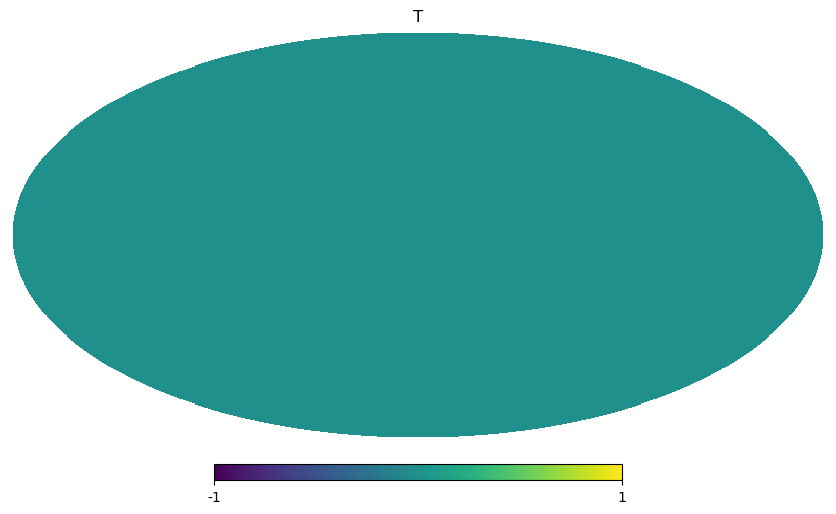

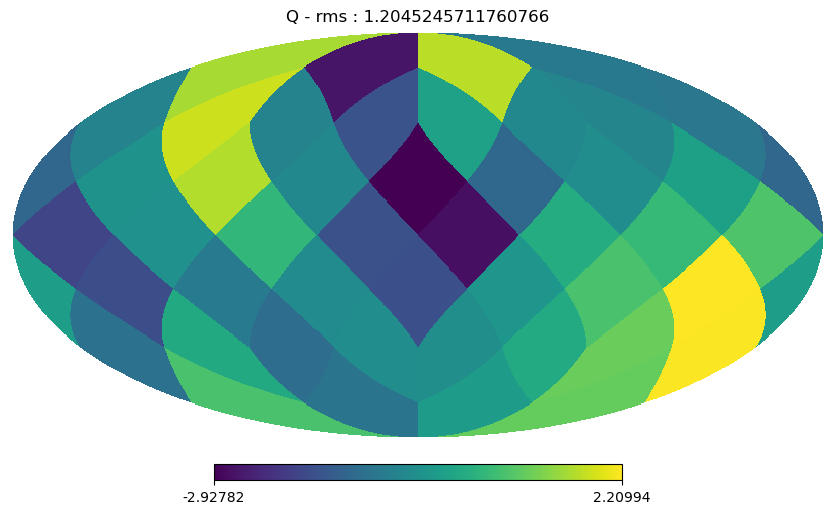

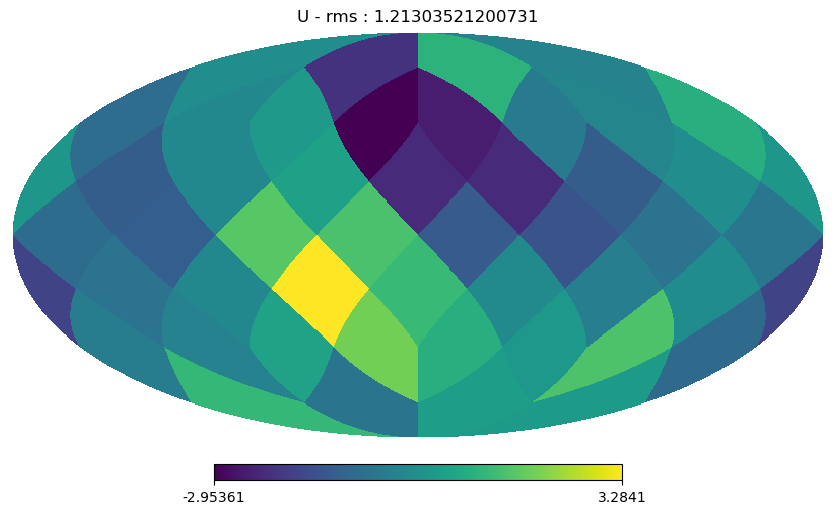

In [121]:
rms_Q_d = np.sqrt(np.sum(np.power(map_divided_spectra_d[1]-np.mean(map_divided_spectra_d[1]), 2))/len(map_divided_spectra_d[1]))
rms_U_d = np.sqrt(np.sum(np.power(map_divided_spectra_d[2]-np.mean(map_divided_spectra_d[2]), 2))/len(map_divided_spectra_d[2]))

hp.mollview(map_divided_spectra_d[0])
plt.title('T')
hp.mollview(map_divided_spectra_d[1])
plt.title('Q - rms : {}'.format(rms_Q_d))
hp.mollview(map_divided_spectra_d[2])
plt.title('U - rms : {}'.format(rms_U_d))
plt.show()

In [142]:
nside_e = 1
full_cell_divided_spectra_e = np.zeros((2*nside_e+1,4))
# full_cell_divided_spectra[2:,1:3] = divided_spectra.T
full_cell_divided_spectra_e[2:,1:3] = 1
# full_cell_divided_spectra_c[2:,1:3] = 1/np.sqrt(12*nside_c**2)



map_divided_spectra_e = hp.synfast(full_cell_divided_spectra_e.T, nside=nside_e, new=True)

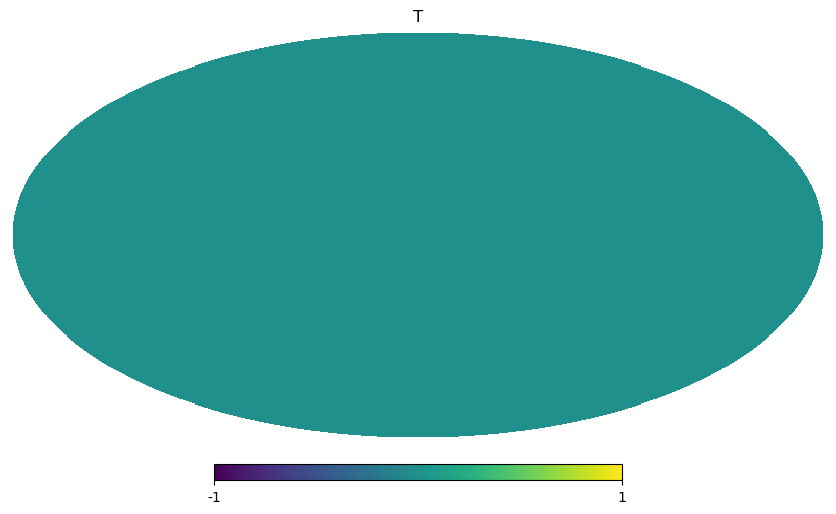

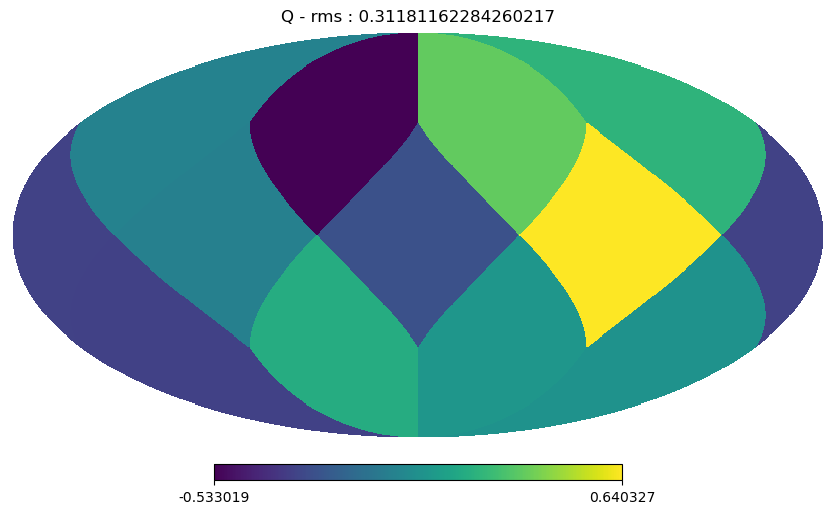

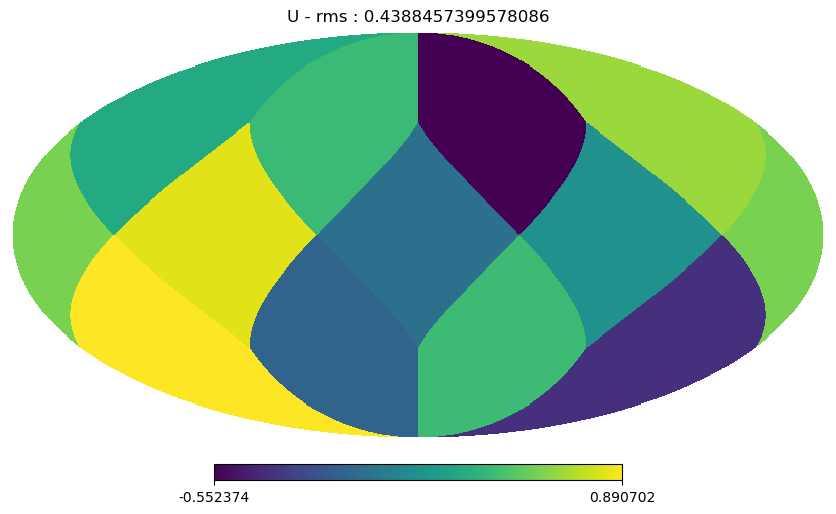

In [143]:
map_to_take_rms = map_divided_spectra_e
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))

# rms_Q_e = np.sqrt(np.sum(np.power(map_to_take_rms[1]-np.mean(map_to_take_rms[1]), 2))/len(map_to_take_rms[1]))
# rms_U_e = np.sqrt(np.sum(np.power(map_to_take_rms[2]-np.mean(map_to_take_rms[2]), 2))/len(map_to_take_rms[2]))
rms_Q_e = rms_func(map_to_take_rms, 1)
rms_U_e = rms_func(map_to_take_rms, 2)

hp.mollview(map_divided_spectra_e[0])
plt.title('T')
hp.mollview(map_divided_spectra_e[1])
plt.title('Q - rms : {}'.format(rms_Q_e))
hp.mollview(map_divided_spectra_e[2])
plt.title('U - rms : {}'.format(rms_U_e))
plt.show()

In [41]:
# alms_Healpy = hp.map2alm(maps_TQU, lmax=2*nside)
alms_Healpy = hp.map2alm(maps_TQU_woTTTE, lmax=2*nside, iter=0)



In [42]:
alms_Healpy.shape

(3, 8385)

In [43]:
camb_cls.shape

(129, 4)

In [109]:
lmax = 2*nside
inv_covariance_matrix_woTETT = np.zeros((lmax, 2, 2))

for ell in range(2,lmax):
    # cov_matrix_woTETT = np.zeros(4)
    cov_matrix_woTETT[0] = camb_cls_woTE[ell,0]
    cov_matrix_woTETT[4] = camb_cls_woTE[ell,1]
    cov_matrix_woTETT[8] = camb_cls_woTE[ell,2]
    cov_matrix_woTETT[1] = camb_cls_woTE[ell,3]
    cov_matrix_woTETT[3] = camb_cls_woTE[ell,3]
    # inv_covariance_matrix[ell] = np.linalg.pinv(cov_matrix.reshape(3,3))
    # inv_covariance_matrix_woTETT[ell] = np.linalg.pinv(cov_matrix_woTETT.reshape(3,3))
    inv_covariance_matrix_woTETT[ell] = np.linalg.pinv(cov_matrix_woTETT.reshape(3,3))

In [123]:
camb_cls_woTE

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.02199001e+03, 3.35969187e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.91008604e-03, 2.20934233e-04, 0.00000000e+00, 0.00000000e+00],
       [5.90311951e-03, 2.19432405e-04, 0.00000000e+00, 0.00000000e+00],
       [5.89695383e-03, 2.17914688e-04, 0.00000000e+00, 0.00000000e+00]])

In [124]:
test = camb_cls_woTE.ravel('F')
print(test[0], test[1], test[2], test[3], test[1024], test[1025], test[1026])

0.0 0.0 1021.9900118923628 483.7071509323783 0.005896953828991165 0.0 0.0


In [117]:
for ell in range(2,10):
    print(camb_cls_woTE[ell,0], camb_cls_woTE[ell,1], camb_cls_woTE[ell,2], camb_cls_woTE[ell,3])

1021.9900118923628 0.03359691870297146 0.0 0.0
483.7071509323783 0.02315608128510505 0.0 0.0
274.5013456857929 0.013027637334701185 0.0 0.0
175.10680532257444 0.006302294117185589 0.0 0.0
121.17800118202051 0.0027046606697523016 0.0 0.0
89.00006953691134 0.001109326489514659 0.0 0.0
68.32718380551444 0.0005157924401573135 0.0 0.0
54.308079002182154 0.0003124439164257774 0.0 0.0


In [110]:
for ell in range(2,10):
    print(inv_covariance_matrix_woTETT[ell])

[[9.78483144e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.97646343e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[2.06736658e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.31851999e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[3.64296939e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.67598893e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[5.71080032e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.58672379e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[8.25232295e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.69732148e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.12359463e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.01447869e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.46354634e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93876436e+03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.

In [46]:
lmax = 2*nside
inv_covariance_matrix = np.zeros((lmax, 3,3))

for ell in range(2,lmax):
    # cov_matrix = np.zeros(9)
    # cov_matrix[0] = camb_cls_woTE[ell,0]
    # cov_matrix[4] = camb_cls_woTE[ell,1]
    # cov_matrix[8] = camb_cls_woTE[ell,2]
    # cov_matrix[1] = camb_cls_woTE[ell,3]
    # cov_matrix[3] = camb_cls_woTE[ell,3]
    cov_matrix = np.zeros(4)
    cov_matrix[0] = camb_cls_woTE[ell,1]
    cov_matrix[3] = camb_cls_woTE[ell,2]
    # inv_covariance_matrix[ell] = np.linalg.pinv(cov_matrix.reshape(3,3))
    cholesky_decomp = np.linalg.cholesky(np.linalg.inv(cov_matrix.reshape(2,2)))
    # cholesky_decomp[0,1] = cholesky_decomp[1,0]
    # cholesky_decomp[0,2] = cholesky_decomp[2,0]
    # cholesky_decomp[1,2] = cholesky_decomp[2,1]
    # cholesky_decomp[1,1] = cholesky_decomp[1,1]
    # cholesky_decomp[1,2] = cholesky_decomp[2,1]
    inv_covariance_matrix[ell][1:,1:] = cholesky_decomp

In [47]:
lmax = 2*nside
alm_T, alm_E, alm_B = alms_Healpy
alm_T_output, alm_E_output, alm_B_output = np.ones_like(alm_T), np.ones_like(alm_E), np.ones_like(alm_B)
for ell in range(2,lmax):
    min_range = int(ell*(ell+1)/2)
    max_range = int((ell+2)*(ell+1)/2)
    alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]*inv_covariance_matrix[ell][0,0] + alm_E[min_range:max_range+1]*inv_covariance_matrix[ell][0,1])
    alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]*inv_covariance_matrix[ell][1,1] + alm_T[min_range:max_range+1]*inv_covariance_matrix[ell][1,0])
    alm_B_output[min_range:max_range+1] = alm_B[min_range:max_range+1]*inv_covariance_matrix[ell][2,2]


In [32]:
lmax = 2*nside
alm_T, alm_E, alm_B = alms_Healpy
alm_T_output, alm_E_output, alm_B_output = np.ones_like(alm_T), np.ones_like(alm_E), np.ones_like(alm_B)
for ell in range(2,lmax):
    min_range = int(ell*(ell+1)/2)
    max_range = int((ell+2)*(ell+1)/2)
    alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/inv_covariance_matrix[ell][0,0] + alm_E[min_range:max_range+1]/inv_covariance_matrix[ell][0,1])
    alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/inv_covariance_matrix[ell][1,1] + alm_T[min_range:max_range+1]/inv_covariance_matrix[ell][1,0])
    alm_B_output[min_range:max_range+1] = alm_B[min_range:max_range+1]/inv_covariance_matrix[ell][2,2]


In [40]:
lmax = 2*nside
alm_T, alm_E, alm_B = alms_Healpy
alm_T_output, alm_E_output, alm_B_output = np.ones_like(alm_T), np.ones_like(alm_E), np.ones_like(alm_B)
for ell in range(2,lmax):
    min_range = int(ell*(ell+1)/2)
    max_range = int((ell+2)*(ell+1)/2)
    alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
    alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,1]) + alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,0]))
    alm_B_output[min_range:max_range+1] = alm_B[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][2,2])


/tmp/ipykernel_56396/1651361668.py:7: RuntimeWarning: invalid value encountered in sqrt
  alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
/tmp/ipykernel_56396/1651361668.py:7: RuntimeWarning: invalid value encountered in divide
  alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
/tmp/ipykernel_56396/1651361668.py:8: RuntimeWarning: invalid value encountered in sqrt
  alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,1]) + alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,0]))
/tmp/ipykernel_56396/1651361668.py:8: RuntimeWarning: invalid value encountered in divide
  alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance

In [48]:
maps_healpy_alms = hp.alm2map((alm_T_output, alm_E_output, alm_B_output), nside=nside)

In [49]:
maps_healpy_alms.shape

(3, 49152)

In [50]:
cls_healpy_alms = hp.anafast(maps_healpy_alms, lmax=2*nside)


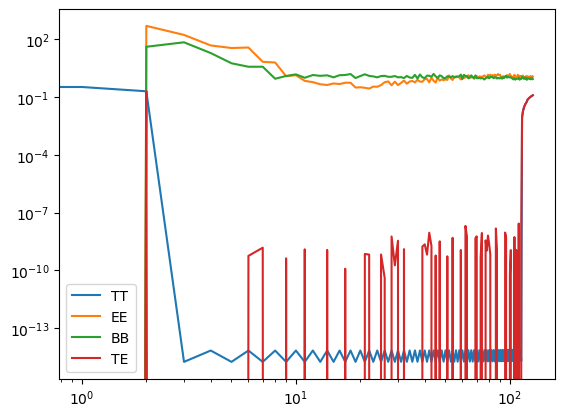

In [51]:
ell_arange = np.arange(cls_healpy_alms.shape[1])

plt.plot(ell_arange, cls_healpy_alms.T[:,:4])
plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

(array([1.000e+00, 3.000e+00, 6.000e+00, 4.000e+00, 4.000e+00, 1.100e+01,
        1.000e+01, 1.400e+01, 2.100e+01, 3.600e+01, 5.300e+01, 7.000e+01,
        8.100e+01, 1.390e+02, 1.530e+02, 1.920e+02, 2.400e+02, 3.090e+02,
        3.680e+02, 4.280e+02, 5.740e+02, 6.570e+02, 7.780e+02, 9.330e+02,
        1.084e+03, 1.232e+03, 1.296e+03, 1.480e+03, 1.640e+03, 1.744e+03,
        1.902e+03, 1.972e+03, 2.035e+03, 2.086e+03, 2.102e+03, 2.068e+03,
        2.174e+03, 2.112e+03, 2.056e+03, 1.964e+03, 1.818e+03, 1.721e+03,
        1.620e+03, 1.436e+03, 1.305e+03, 1.126e+03, 1.026e+03, 9.250e+02,
        7.720e+02, 6.630e+02, 5.600e+02, 4.990e+02, 3.490e+02, 2.890e+02,
        2.400e+02, 1.830e+02, 1.460e+02, 1.120e+02, 9.100e+01, 5.900e+01,
        5.500e+01, 3.100e+01, 2.400e+01, 1.900e+01, 2.400e+01, 1.100e+01,
        4.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00]),
 array([-154.19704178, -149.8549027 , -145.51276362, -141.17062454,
        -136

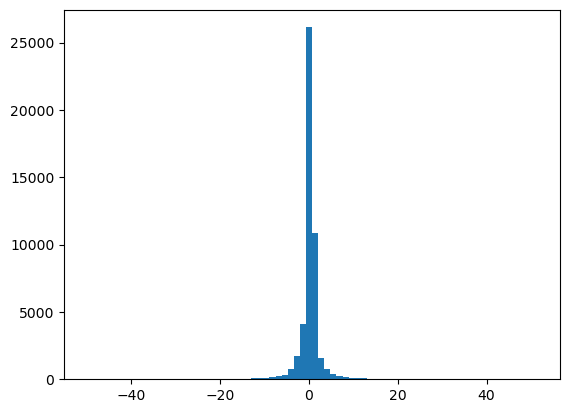

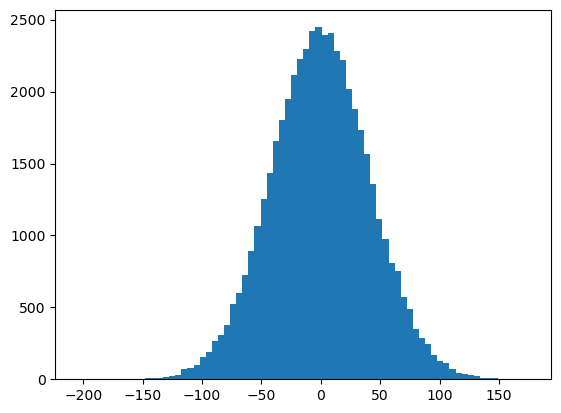

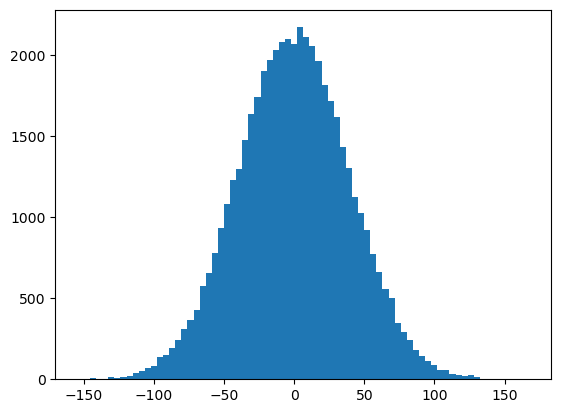

In [52]:
plt.figure()
plt.hist(maps_healpy_alms[0], bins='rice')
plt.figure()
plt.hist(maps_healpy_alms[1], bins='rice')
plt.figure()
plt.hist(maps_healpy_alms[2], bins='rice')